# Прогнозирование оттока пользователей

**Краткая информация:** 
Отток пользователей - одна из наиболее актуальных задач в областях, где распространение услуги составляет порядка 100%. Ярким примером такой области является сфера телекома. Поэтому особенно важным становится именно удержание клиентов, а не привлечение новых. Кроме того, поскольку данные пользователей обфусцированы, мы не имеем представления о значении и роли каждой переменной в данных.  
В терминах машинного обучения мы решаем задачу бинарной классификации: отток и не отток.  
Полученная система позволит находить клиентов, склонных к оттоку (телеком-оператора) по их поведению и последующих мероприятий, связанных с удержанием клиентов. Примером таких мероприятий может быть обзвон клиентов и предложение более выгодного тарифного плана или скидка на текущий тарифный план.

Данные были взяты их соревнования KDD Cup: Customer relationship prediction 2009 года. http://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro 
Предоставлены данные французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированы: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные

# 1. Импорт

In [ ]:
!pip install catboost
!pip install scikit-plot

     |████████████████████████████████| 67.3MB 57kB/s 


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import (cross_val_score, train_test_split, 
StratifiedKFold, GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from scikitplot.plotters import plot_roc_curve, plot_precision_recall_curve

from catboost import CatBoostClassifier

In [ ]:
# Загружаем данные
!gdown --id 14rsU-yPlfx6am_nmHcgCmPx1C6mHIYkU

Downloading...
From: https://drive.google.com/uc?id=14rsU-yPlfx6am_nmHcgCmPx1C6mHIYkU
To: /content/orange_small_churn_data.txt
23.7MB [00:00, 89.7MB/s]


In [ ]:
#Загружаем ответы
!gdown --id 1pIIsMJZebdCIyNHtWNUS13wkYZYPmUih

Downloading...
From: https://drive.google.com/uc?id=1pIIsMJZebdCIyNHtWNUS13wkYZYPmUih
To: /content/orange_small_churn_labels.txt
100% 117k/117k [00:00<00:00, 35.5MB/s]


In [ ]:
data = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt', header=None).values.flatten()

Заменяем -1 на 0 ради удобства

In [ ]:
labels[labels==-1] = 0

In [ ]:
data.shape, labels.shape

((40000, 230), (40000,))

In [ ]:
data.sample(5)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
28805,NaN,NaN,NaN,NaN,NaN,1610.0,21.0,NaN,NaN,NaN,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348.0,435.0,NaN,6.0,192.0,NaN,NaN,297.44,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1555926.0,NaN,NaN,...,NaN,8Iqt0G8rTN,RO12,NaN,taul,1K8T,PbOJ,EQsMhNR,9YuuPSz3BI,NaN,NaN,2kDj,9_Y1,e7QV,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,54Ak,UYBR,NaN,KVX8iqZ,oslk,3A8Rt2K,NaN,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,938.0,0.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,DHeq9ayfAo,2Knk1KF,SEuy,taul,1K8T,z32l,Te2s8CN,glRBFJT8NN,4vEpxtA,smXZ,szaj,9_Y1,vm5R,VpdQ,sYC_,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,yQGUiCJ,NaN,XTbPUYD,FWMv,UYBR,FzaX,rDm6pd1,oslk,Q53Rkup,LM8l689qOp,NaN,kG3k,7P5s,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,NaN
14531,NaN,NaN,NaN,NaN,NaN,721.0,7.0,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,220.0,NaN,4.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,135552.0,NaN,NaN,...,NaN,zKnr4RXktW,RO12,SEuy,taul,1K8T,z32l,XvJdiSi,yEFIHeU,L3fRQZl,smXZ,8lFO,9_Y1,Cgc3,VpdQ,sYC_,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,8qJQbPB,NaN,kq0aHkC,65YR,cJvF,FzaX,nEyOVQC,oslk,DenTzYj,LM8l689qOp,NaN,xG3x,Xa3G,RAYp,F2FyR07IdsN7I,mj86,NaN
12328,NaN,NaN,NaN,NaN,NaN,560.0,7.0,NaN,NaN,NaN,NaN,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,155.0,NaN,0.0,88.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4480506.0,NaN,NaN,...,NaN,ypNt0Go8Lb,RO12,NaN,taul,1K8T,xgSF,XPJ4lx4,9YuuPSz3BI,NaN,NaN,MWHD,9_Y1,MGOA,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,mAjbk_S,tP0k,cJvF,NaN,806OVQC,oslk,Wb5QQMs,NaN,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
30114,NaN,NaN,NaN,NaN,NaN,7021.0,7.0,NaN,NaN,NaN,NaN,NaN,4508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2848.0,3560.0,NaN,12.0,800.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3198312.0,NaN,NaN,...,NaN,LDPgUHXZeb,2Knk1KF,SEuy,taul,1K8T,487l,AKbblEW,n1zVHpT8NN,nq_PygS,smXZ,ZIlk,9_Y1,STGZ,09_Q,Tkho,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,d52X9VG,NaN,kq0mj86,s9FI,UYBR,AU8_WTd,bYA18fN,oslk,aFcwIB5,jySVZNlOJy,NaN,kG3k,453m,RAYp,55YFVY9,am7c,NaN


Смотрим на распределение целевой переменной

[37024  2976]


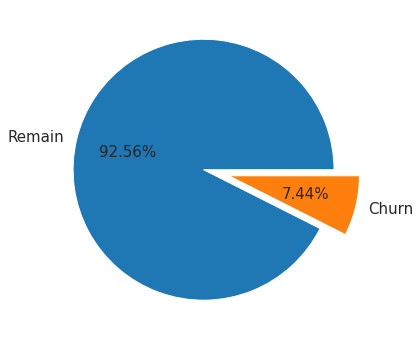

In [ ]:
plt.figure(figsize=(9,6))
plt.pie(np.unique(labels, return_counts=True)[1], labels=['Remain', 'Churn'],
        explode=(0, 0.2), autopct='%1.2f%%',  textprops={'fontsize': 15});
print(np.unique(labels, return_counts=True)[1])

Как мы можем видеть, данные не сбалансированы.

# 2. Предообработка

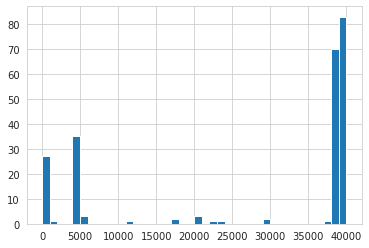

In [ ]:
data.isnull().sum().hist(bins=40)

Как мы видим, большинство признаков содержат свыше 35 тыс. пропущенных значений. Поскольку при обучении с ними может быть много проблем, мы от них избавимся.

In [ ]:
# threshold - доля непропущенных значений, которую колонка должна иметь, чтобы остаться в датафрейме
def preprocessing(data, threshold=0.25):

  data.dropna(axis=1, thresh=threshold*data.shape[0], inplace=True)

  # Определяем категориальные и дискретные данные
  cat_features = list(data.dtypes[data.dtypes == 'object'].index)
  num_features = list(data.dtypes[~(data.dtypes == 'object')].index)

  # Для дискретных принаков будем заменять пропущенные значения средними
  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean'))]) 

  # Для категориальных принаков будем замерять пропущенные значения константами
  categor_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant'))])

  # Собираем в один трансформер
  preprocessor = ColumnTransformer(transformers=[
      ('numeric_transformer', numeric_transformer, num_features),
      ('categor_transformer', categor_transformer, cat_features)])
  
  # Преобразовываем данные
  data_bst = pd.DataFrame(preprocessor.fit_transform(data), columns=num_features+cat_features)
  
  return data_bst, cat_features, num_features

In [ ]:
data_bst, cat_features, num_features = preprocessing(data)

# 3. Описательный анализ данных

Проведём анализ наиболее полезных с точки зрения предсказательной силы признаков на основе посредством метода f_classif, функционирующего на основе теста ANOVA и сравнить эти значения с регрессионными оценками этих признаков с зависимой переменной. 

In [ ]:
def num_selection(df, num_features, labels, k):
  X = df[num_features] 
  y = labels    
  cols = X.columns

  bestfeatures = SelectKBest(k=k).fit(X,y)
  featureScores = pd.DataFrame({'Var' : cols, 'Score': bestfeatures.scores_})
  
  regr = pd.DataFrame({'Var': cols,
                     'Regr':abs(X[cols][y==0].mean(axis=0) - X[cols][y==1].mean(axis=0))})
  
  feature_table = featureScores.merge(regr).sort_values(by='Score', ascending=False).round(3)
  feature_table.set_index('Var', inplace=True)

  best_num = list(feature_table.index)[:k]

  return feature_table, best_num

In [ ]:
feature_table, best_num = num_selection(data_bst, num_features, labels, 20)
print(', '.join(best_num))
feature_table.T

Var189, Var73, Var7, Var113, Var144, Var13, Var126, Var65, Var81, Var74, Var72, Var140, Var6, Var28, Var125, Var160, Var119, Var149, Var94, Var143


Var,Var189,Var73,Var7,Var113,Var144,Var13,Var126,Var65,Var81,Var74,Var72,Var140,Var6,Var28,Var125,Var160,Var119,Var149,Var94,Var143,Var24,Var173,Var85,Var25,Var153,Var132,Var76,Var35,Var21,Var22,Var38,Var134,Var112,Var109,Var78,Var57,Var163,Var83,Var181,Var133,Var44,Var123
Score,257.069,194.420,193.934,126.342,105.814,86.270,70.999,68.566,47.440,42.208,36.352,30.111,16.397,8.607,8.561,6.504,4.900,4.624,4.514,4.082,4.029,3.947,3.669,3.641,3.242,2.715,2.540,2.356,2.276,2.227,1.782,1.625,1.194,1.007,0.852,0.476,0.412,0.345,0.189,0.069,0.010,0.000
Regr,17.107,14.021,1.569,162842.185,2.166,444.065,3.067,1.491,13285.306,45.688,0.195,410.325,189.837,5.193,4888.014,4.513,82.722,25531.153,5192.693,0.024,0.351,0.005,0.720,7.309,141460.232,0.295,53034.207,0.082,15.166,18.767,72546.154,13956.777,3.130,2.515,0.035,0.027,9784.111,0.912,0.020,11572.166,0.003,0.087


Как можно видеть, некоторые важные переменные имеют неилинейную связь с зависимой переменной.

In [ ]:
data_and_labels = pd.concat([data, pd.Series(labels)], axis=1)
data_and_labels.columns = list(data_and_labels.columns[:-1]) + ['Churn']
data_and_labels['all'] = ''

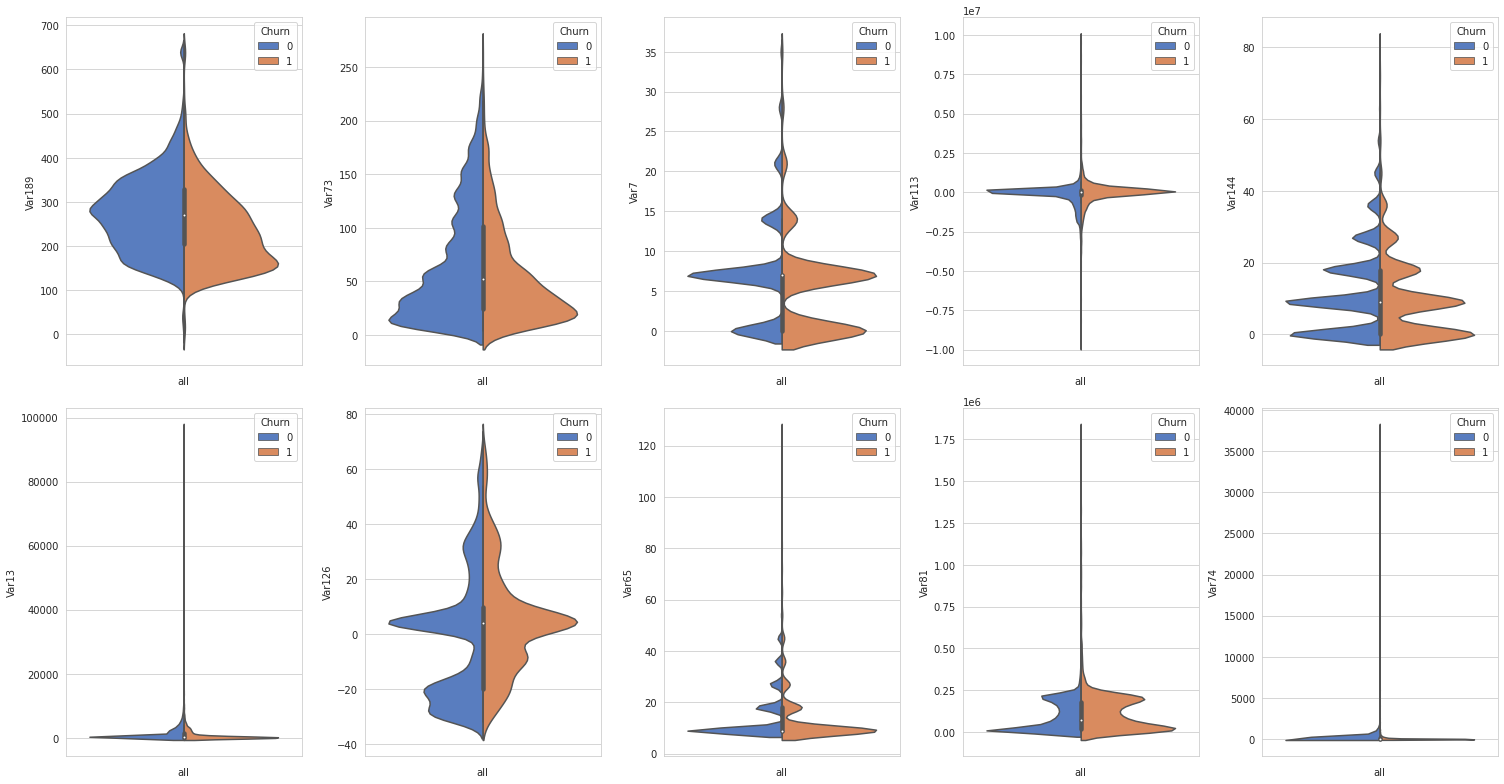

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(21,11));
features = list(feature_table.index[:10])
for i, axis in enumerate(axes.flat):
    feature = features[i]
    sns.violinplot(x='all', y=feature, hue='Churn', split=True, data=data_and_labels, orient='v',
                    scale="width", palette="muted", ax=axis, )
    #sns.boxplot(x=feature, y=data_and_labels.Churn.astype(str),  ax=axis)
plt.tight_layout()

Как можно видеть, нелинейная связь некоторых переменных обусловлена волнообразными характером их распределения.

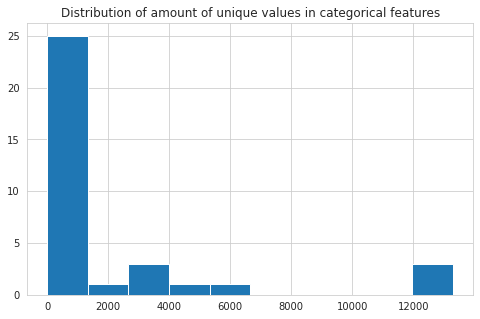

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(data_bst[cat_features].describe().T.unique.values)
plt.title('Distribution of amount of unique values in categorical features');

Большинство категориальных переменных имеют немного уникальных значений, однако некоторые из них имеют больше 2000 тысяч уникальных значений.  
Оценим распределение признаков, имеющих менее 50 уникальных значений.

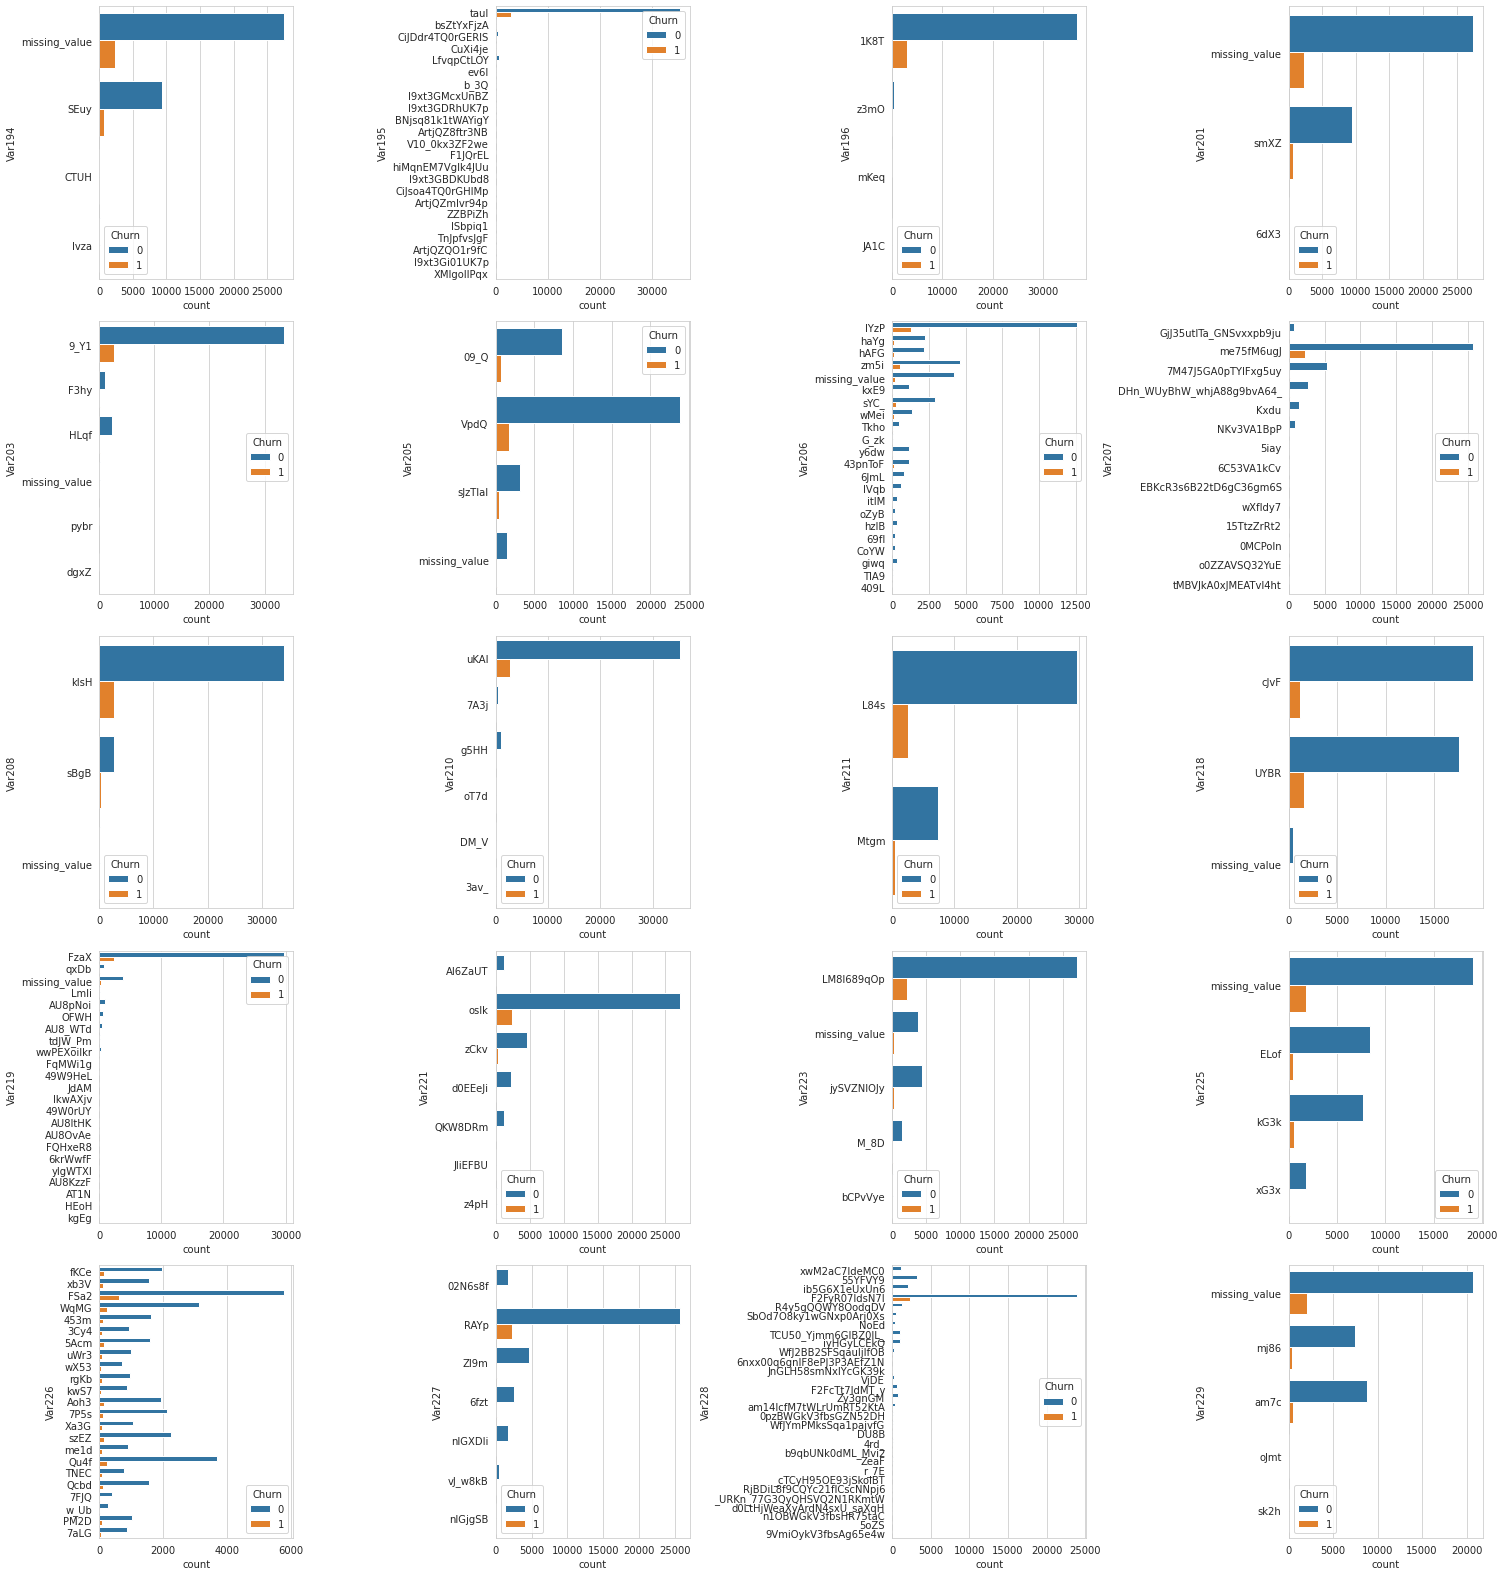

In [ ]:
bst_data_and_labels = pd.concat([data_bst, pd.Series(labels)], axis=1)
bst_data_and_labels.columns = list(bst_data_and_labels.columns[:-1]) + ['Churn']

unique_dist = data_bst[cat_features].describe().T.unique
fig, axes = plt.subplots(5,4, figsize=(21,22));
features = unique_dist[unique_dist < 50].index
for i, axis in enumerate(axes.flat):
    feature = features[i]
    distr = bst_data_and_labels[feature].value_counts
    sns.countplot(y=feature, data=bst_data_and_labels, hue='Churn', ax=axis)

plt.tight_layout()

Опираясь на распределение категориальных переменных сложно сказать что-то определённое. В большинстве переменных есть 1-3 наиболее часто встречающихся значений. Ни при одном из значений нету преобладание объектов класса "отток", однако соотношение их количества в разных значений различается, хотя и незначительно.  

# 4. Построение модели

Для обучения будем использовать **Catboost** - метод градиентного бустинга с продвинутой техникой работы с категориальными признаками.  
Кросс-валидации при подборе параметров будет проведена с применением метода **StratifiedKFold** - разделение выборки на k значений с сохранением соотношения классов и перемешиванием значений.

In [ ]:
SKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)

Находим оптимальные веса для модели на основе распределения классов в целевой переменной.

In [ ]:
classes = class_weight.compute_sample_weight('balanced', np.unique(labels), labels)
classes

array([0.54019015, 6.72043011])

In [ ]:
%%time
params = {'learning_rate' : [0.01, 0.05],
         'l2_leaf_reg': [5,8],
          'depth': [3,5],
         'loss_function': ['Logloss'],
         'iterations': [300]}
cb = CatBoostClassifier(eval_metric = 'AUC', cat_features = cat_features, verbose=False, class_weights=classes)
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = SKFold,  
                        n_jobs=-1, verbose=1)
cb_model.fit(data_bst, labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 30.0min finished


CPU times: user 2min 34s, sys: 5.31 s, total: 2min 39s
Wall time: 31min 8s


Получаем наилучшие параметры модели.

In [ ]:
print(cb_model.best_params_)
print(cb_model.best_score_)
cb_best = cb_model.best_estimator_

{'depth': 5, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'loss_function': 'Logloss'}
0.7470452604296308


Сразу же разделим датасет на тренировочную и тестовую выборку (с размером 0.5 от первоначальной).  
На первой будем проводить обучение, на второй - строить бизнес-модель.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_bst, labels, test_size=0.5, stratify=labels, random_state=314)

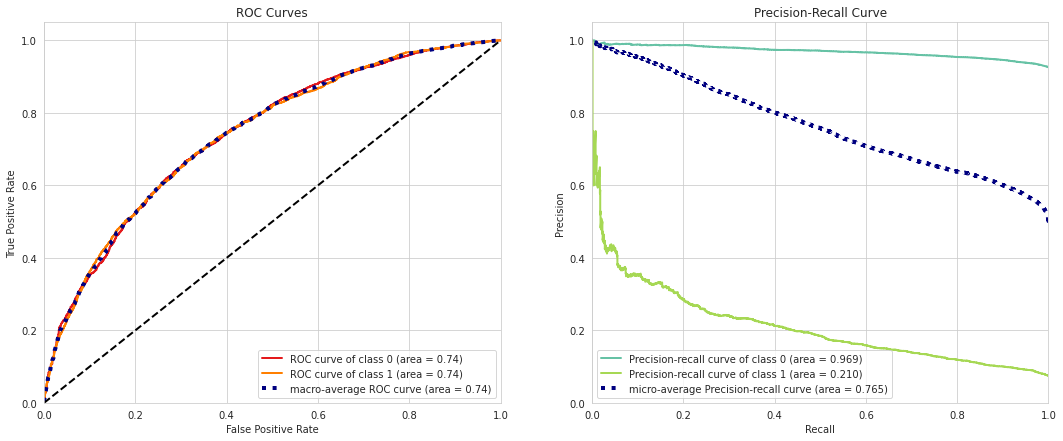

In [ ]:
def catboost(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=314)

  model.fit(X_train, y_train, verbose=False, eval_set=(X_test, y_test), early_stopping_rounds=20)
  
  pred = model.predict_proba(X_test)

  fig, ax = plt.subplots(1,2, figsize=(18,7))
  plot_roc_curve(y_test, pred, title_fontsize='large', curves=('each_class', 'macro'),  text_fontsize='medium', cmap='Set1', ax=ax[0])
  plot_precision_recall_curve(y_test, pred, title_fontsize='large',  text_fontsize='medium', cmap='Set2', ax=ax[1]);
  
  probs = pd.DataFrame({'pred' : pred[:,1], 'labels' : y_test}).sort_values(by='pred', ascending=False)
  return probs
probs = catboost(cb_best, data_bst, labels)

Несмотря на хорошее значение ROC-AUC, модель не самым лучшим образом предсказывает отток клиентов, вследствие чего нам придётся искать баланс между высокой точностью (Precision) и большим числом ложно-негативных срабатываний или высокой полнотой (Recall) и большим числом ложно-положительных срабатываний.


# 5. Постановка задачи и бизнес-модель

1. Определяется $N$ пользователей мобильного оператора, по прогнозу наиболее склонных к оттоку на основании предсказания
2. Им рассылается SMS с предложением подключить более дешёвый тариф, чья стоимость будет сосвавлять долю $d$ от стандартного тарифа стоимостью $p$ на протяжение m месяцев. 
3. Пользователи $O$, не склонные к оттоку, в любом случае воспользуются предложением до окончания периода предложения
4. С вероятностью $s$ процентов пользователи, склонные к оттоку (из количества, равного $C$), останутся клиентом фирмы, воспользуются скидкой и будет пользоваться до окончания периода предложения.
5. Также скидка будет предлагаться всем новым пользователям, доля которых будет составлять $NU$ процентов каждый месяц до $m + 1$-ого месяца (с момента начала отсчёта).  
6. $92.5$ процентов останутся пользователями. Остальные перестанут пользоваться фирмы после 1 месяца использования
7. Будем сравнивать прибыль: 1) после проведения кампании по удержанию при разном количестве пользователей; 2) без проведения кампании по удержанию.

In [32]:
def campaign2(N, p, d, m, s, NU, probs):
  C = probs[:N].query('labels == 1').shape[0] #правильно определённые клиенты
  Rest = probs[N:].query('labels == 0').shape[0] #клиенты, не склонные к оттоку и не вошедшие в топ

  Revenue_old = C * s * p * (1-d) * m + Rest * p #доход за m месяцев от доли пользователей, решивших остаться
  Cost =  (N-C) * p * d # затраты на удержание выбранных пользователей

  Revenue_new = 0
  old_users = probs.shape[0] #количество пользователей из первоначальной выборки
  for i in range(m):
    new_users = NU * old_users # вычисляем количество новых пользователей за месяц
    Revenue_new += p * (1-d) * (m - i) * new_users * 0.925  + 0.075 * p * (1-d) * new_users #доход, который сгенерируют новые пользователи до конца периода 
    Cost +=  new_users * d * p #затраты на новых пользователей
    old_users += new_users * 0.925 #общее количество пользователей увеличивается

  Profit = Revenue_new + Revenue_old - Cost
  return Profit

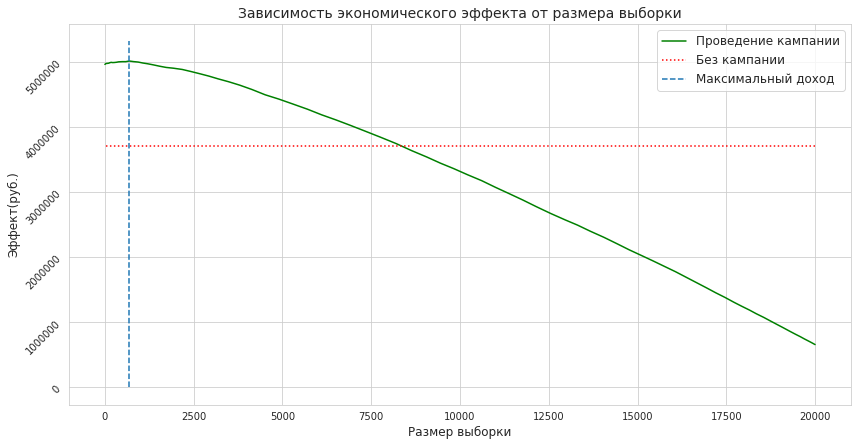

Наиболее оптимальным порогом являются 688 пользователей, участвующих в кампании по удержанию, или 3.4% от общего количества.
Размер выручки при этом составит 5.015 млн. рублей, что на 1.269 млн. превышает выручку без проведения кампании.

Кампанию выгодно проводить до порога в 8205 пользователей, или 41.0% от общего количества.


In [121]:
def campaign_metrics_2(p, d, m, s, NU, probs):
  top_n, top_prec = [], []
  for i in np.arange(0.01, 0.92, 0.01):
    n = probs[probs['pred'] > i].shape[0]
    pr = probs[:n][probs['labels'] == 1].shape[0]
    share = pr / n
    top_n.append(n)
    top_prec.append((pr, share))
  campaign_list = []
  for n in top_n:
    campaign_list.append(campaign2(n, p, d, m, s, NU, probs))
  
  no_campaign = probs.query('labels==0').shape[0]*p
  income_sample = sorted(list(zip(campaign_list, top_n)), key = lambda x: x[0], reverse=True)

  plt.figure(figsize=(14,7))
  plt.plot(top_n, campaign_list,  color="g", label='Проведение кампании')
  plt.plot(top_n, np.ones(len(top_n))*no_campaign, ':',  color="r", label='Без кампании')
  plt.plot(np.ones(len(top_n))*income_sample[0][1], 
           np.linspace(0, income_sample[0][0]+300000, len(top_n)), '--', label='Максимальный доход')
  plt.title('Зависимость экономического эффекта от размера выборки', fontdict={'fontsize':14})
  plt.grid(True)
  plt.xlabel('Размер выборки', fontsize=12)
  plt.ylabel('Эффект(руб.)', fontsize=12)
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.yticks(rotation=45)
  plt.legend(fontsize=12)
  plt.show()

  
  last_profit = np.asarray(income_sample)[np.asarray(income_sample)[:,0] > no_campaign][-1]
  print(f'Наиболее оптимальным порогом являются {income_sample[0][1]} пользователей, ' 
  f'участвующих в кампании по удержанию, или {round((income_sample[0][1] / y_test.shape[0] * 100),1)}% от общего количества.')
  print(f'Размер выручки при этом составит {round(income_sample[0][0]/ 1000000, 3)} млн. рублей, что на {round((income_sample[0][0] - last_profit[0])/ 1000000, 3)}'
  f' млн. превышает выручку без проведения кампании.')
  print()
  print(f'Кампанию выгодно проводить до порога в {int(last_profit[1])} пользователей, или {round((last_profit[1] / y_test.shape[0] * 100),1)}% от общего количества.')
  return income_sample
income_sample = campaign_metrics_2(200, 0.5, 12, 0.7, 0.01, probs)

# 6. Выводы

Для данного эксперимента размер оптимального топа составляет 3-4%, при таком размере экономический эффект максимальный. Мы таким образом получаем прибыль примерно в 1.269 млн рублей в сравнении с тем, если мы не будет проводить компанию по предотвращению оттока (которая также будет привлекать новых клиентов).